# 3. AQC-Tensor

In [30]:
from ropt_aqc.initialise_hamiltonians import get_hamiltonian_terms, build_matrix_from_terms

method = 'AQC'
num_sites = 6
degree = 2
n_repetitions = 5
n_id_layers = 0
evolution_time = 0.2

In [31]:
# Ising-1d
J=1.
g=0.75
h=0.6
system = 'ising-1d'

terms, params = get_hamiltonian_terms(num_qubits=num_sites, system=system, J=J, g=g, h=h)

J = params['J']
h = params['h']
g = params['g']

In [32]:
from ropt_aqc.initialise_hamiltonians import hamiltonian_to_sparse_pauli_op
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler import CouplingMap

hamiltonian = hamiltonian_to_sparse_pauli_op(terms, num_qubits=num_sites)
print('Hamiltonian: ', hamiltonian)

observable = SparsePauliOp.from_sparse_list(
    [("ZZ", (num_sites // 2 - 1, num_sites // 2), 1.0)], num_qubits=num_sites
)
print("Observable:", observable)

Hamiltonian:  SparsePauliOp(['ZZIIII', 'IZZIII', 'IIZZII', 'IIIZZI', 'IIIIZZ', 'ZIIIII', 'XIIIII', 'IZIIII', 'IXIIII', 'IIZIII', 'IIXIII', 'IIIZII', 'IIIXII', 'IIIIZI', 'IIIIXI', 'IIIIIZ', 'IIIIIX'],
              coeffs=[1.  +0.j, 1.  +0.j, 1.  +0.j, 1.  +0.j, 1.  +0.j, 0.6 +0.j, 0.75+0.j,
 0.6 +0.j, 0.75+0.j, 0.6 +0.j, 0.75+0.j, 0.6 +0.j, 0.75+0.j, 0.6 +0.j,
 0.75+0.j, 0.6 +0.j, 0.75+0.j])
Observable: SparsePauliOp(['IIZZII'],
              coeffs=[1.+0.j])


In [33]:
# construct initial state
from qiskit import QuantumCircuit

# Generate an initial state
initial_state = QuantumCircuit(num_sites)
for i in range(num_sites):
    if i % 2:
        initial_state.x(i)

In [34]:
# initial time evolution
from qiskit.synthesis import SuzukiTrotter
from qiskit_addon_utils.problem_generators import generate_time_evolution_circuit

# Generate the AQC target circuit (initial segment)
aqc_evolution_time = evolution_time
aqc_target_num_trotter_steps = 32

aqc_target_circuit = initial_state.copy()
aqc_target_circuit.compose(
    generate_time_evolution_circuit(
        hamiltonian,
        synthesis=SuzukiTrotter(reps=aqc_target_num_trotter_steps),
        time=aqc_evolution_time,
    ),
    inplace=True,
)

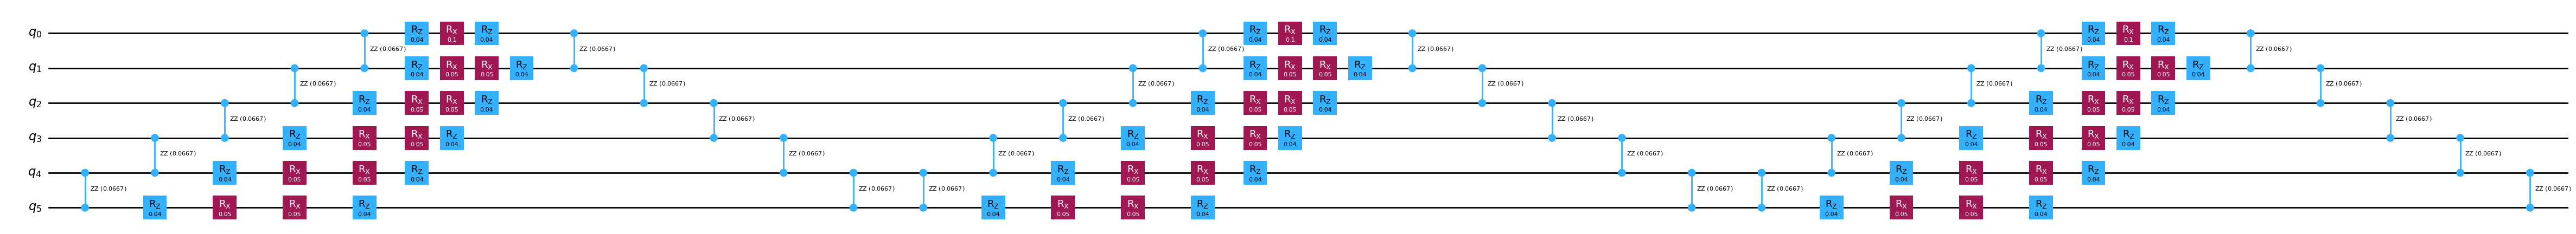

In [35]:
# Generate the subsequent circuit
subsequent_num_trotter_steps = 3
subsequent_evolution_time = 0.2

subsequent_circuit = generate_time_evolution_circuit(
        hamiltonian,
        synthesis=SuzukiTrotter(reps=subsequent_num_trotter_steps),
        time=subsequent_evolution_time,
    )
subsequent_circuit.draw("mpl", fold=-1)

Number of Trotter steps for comparison: 3


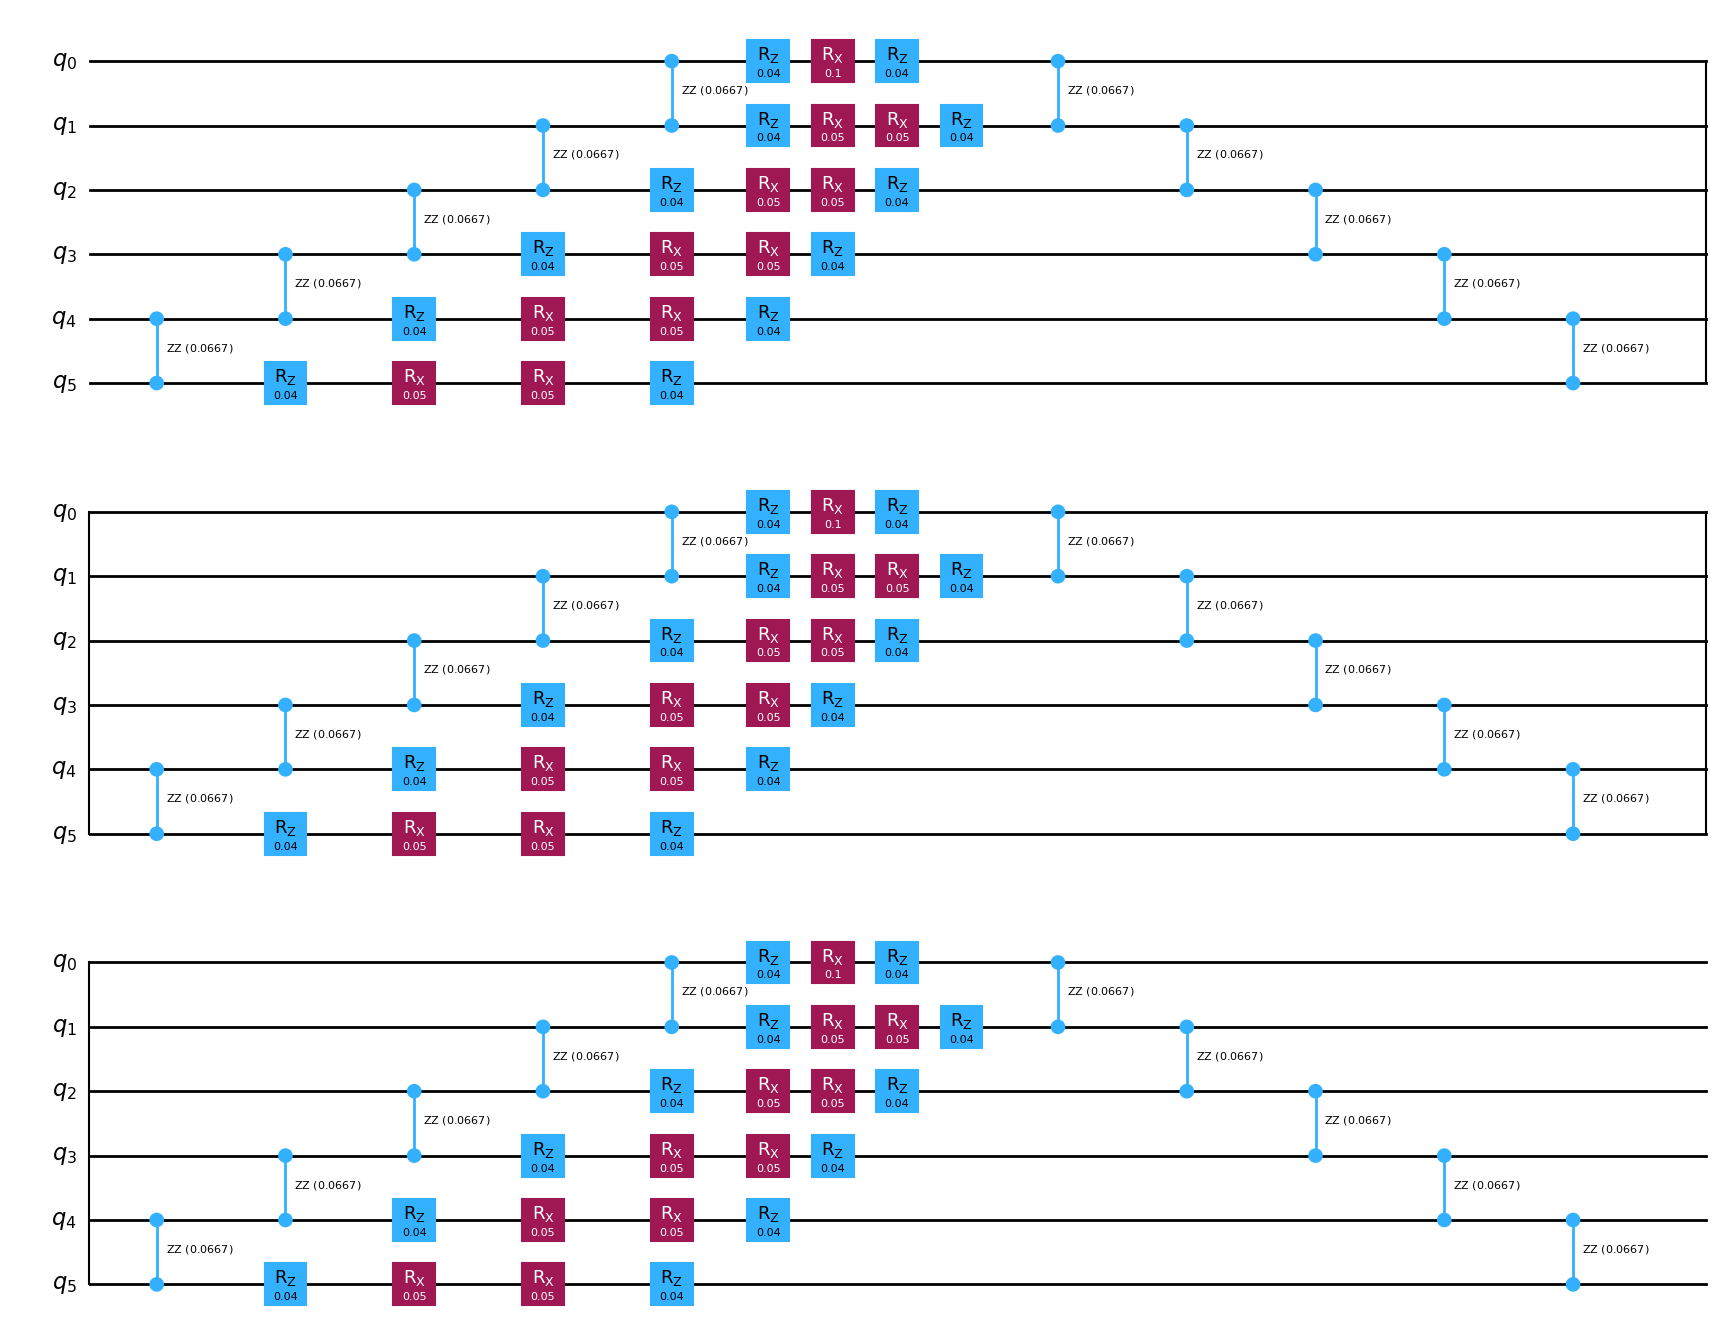

In [36]:
# Generate the AQC comparison circuit
aqc_comparison_num_trotter_steps = int(
    subsequent_num_trotter_steps / subsequent_evolution_time * aqc_evolution_time
)
print("Number of Trotter steps for comparison:", aqc_comparison_num_trotter_steps)

aqc_comparison_circuit = generate_time_evolution_circuit(
    hamiltonian,
    synthesis=SuzukiTrotter(reps=aqc_comparison_num_trotter_steps),
    time=aqc_evolution_time,
)
aqc_comparison_circuit.draw('mpl')

In [37]:
# Generate the reference circuit
evolution_time = evolution_time
reps = 200

reference_circuit = initial_state.copy()
reference_circuit.compose(
    generate_time_evolution_circuit(
        hamiltonian,
        synthesis=SuzukiTrotter(reps=reps),
        time=evolution_time,
    ),
    inplace=True,
)

Generate an ansatz and initial parameters from a Trotter circuit with fewer steps



In [38]:
from qiskit_addon_aqc_tensor.ansatz_generation import generate_ansatz_from_circuit

aqc_ansatz_num_trotter_steps = 5

aqc_good_circuit = initial_state.copy()
aqc_good_circuit.compose(
    generate_time_evolution_circuit(
        hamiltonian,
        synthesis=SuzukiTrotter(reps=aqc_ansatz_num_trotter_steps),
        time=aqc_evolution_time,
    ),
    inplace=True,
)

aqc_ansatz, aqc_initial_parameters = generate_ansatz_from_circuit(aqc_good_circuit)
# aqc_ansatz.draw("mpl", fold=-1)

In [39]:
print(f"AQC Comparison circuit: depth {aqc_comparison_circuit.depth()}")
print(f"Target circuit:         depth {aqc_target_circuit.depth()}")
print(f"Ansatz circuit:         depth {aqc_ansatz.depth()}, with {len(aqc_initial_parameters)} parameters")
# print(f"Ansatz circuit sliced:  depth {aqc_truncated.depth()}, with {len(aqc_params_truncated)} parameters")


AQC Comparison circuit: depth 42
Target circuit:         depth 449
Ansatz circuit:         depth 83, with 387 parameters


Choose Settings for Tensor Network Simulation



In [40]:
import quimb.tensor
from qiskit_addon_aqc_tensor.simulation.quimb import QuimbSimulator

simulator_settings = QuimbSimulator(quimb.tensor.CircuitMPS, autodiff_backend="jax")

In [41]:
# generate MPS representation of the target state, handles efficiently the entanglement
from qiskit_addon_aqc_tensor.simulation import tensornetwork_from_circuit

aqc_target_mps = tensornetwork_from_circuit(aqc_target_circuit, simulator_settings)
print("Target MPS maximum bond dimension:", aqc_target_mps.psi.max_bond())

# Obtains the reference MPS, where we can obtain the exact expectation value by examing the `local_expectation``
reference_mps  = tensornetwork_from_circuit(reference_circuit, simulator_settings)
reference_expval = reference_mps.local_expectation(quimb.pauli('Z') & quimb.pauli('Z'), (num_sites // 2 - 1, num_sites // 2)).real.item()
print("Reference MPS maximum bond dimension:", reference_mps.psi.max_bond())

Target MPS maximum bond dimension: 2
Reference MPS maximum bond dimension: 2


In [42]:
from ropt_aqc.comparison_methods import compress_AQC

N_vals = range(1,30)
df, aqc_truncated, aqc_initial_parameters, aqc_final_parameters = compress_AQC(aqc_ansatz, aqc_good_circuit, aqc_comparison_circuit, aqc_target_circuit, aqc_initial_parameters, N_vals, simulator_settings, aqc_target_mps, n_repetitions)


=== Optimizing with N = 1 layers ===
Parameters in truncated ansatz: ParameterView([ParameterVectorElement(theta[0]), ParameterVectorElement(theta[1]), ParameterVectorElement(theta[2]), ParameterVectorElement(theta[3]), ParameterVectorElement(theta[4]), ParameterVectorElement(theta[5]), ParameterVectorElement(theta[6]), ParameterVectorElement(theta[7]), ParameterVectorElement(theta[8]), ParameterVectorElement(theta[9]), ParameterVectorElement(theta[10]), ParameterVectorElement(theta[11]), ParameterVectorElement(theta[12]), ParameterVectorElement(theta[13]), ParameterVectorElement(theta[14]), ParameterVectorElement(theta[15]), ParameterVectorElement(theta[16]), ParameterVectorElement(theta[17])])
Truncated parameter values: [-3.11759265  1.54077237 -1.57079633 -1.57079633  1.57079633  4.71238898
 -1.57079633  1.57079633  4.71238898 -1.57079633  1.57079633  1.57079633
 -1.57079633  1.57079633  4.71238898 -1.57079633  1.57079633  4.71238898]
AQC Comparison circuit: depth 42
Target circui

In [43]:
import pandas as pd
file_path_ising = f'/Users/aag/Documents/ropt-aqc/method_comparison/results/AQC_initial_Ising_results_{evolution_time}.csv'

df.to_csv(file_path_ising, index=False, header=True)
# df.to_csv(file_path_ising, index=False, mode="a", header=False)


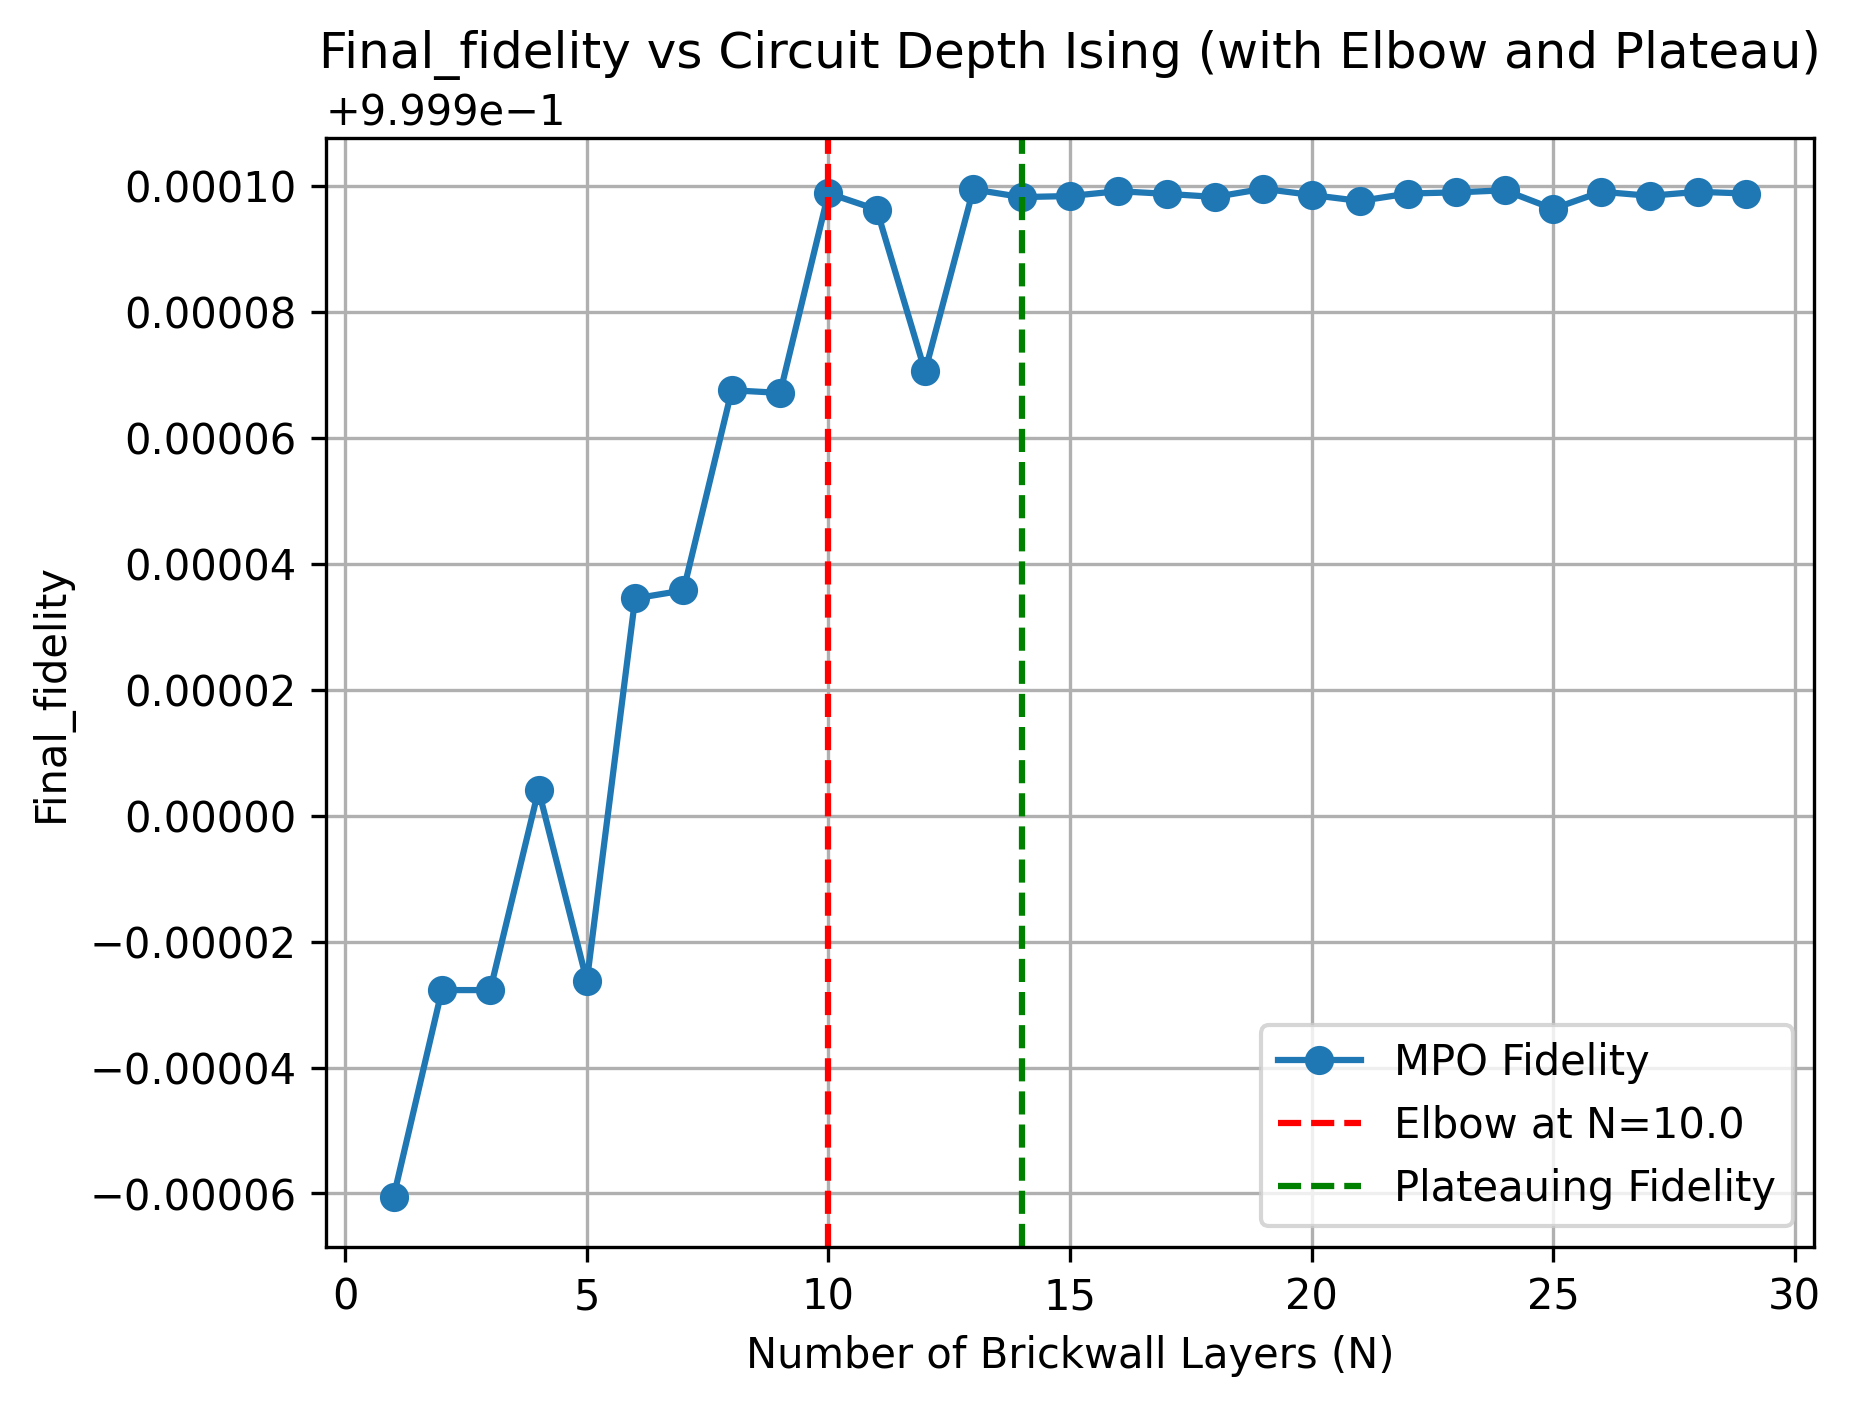


🔍 Suggested optimal compression depth: N = 14.0


In [44]:
from ropt_aqc.brickwall_opt import plot_fidelity
df = pd.read_csv(file_path_ising)
elbow_N, plateau_N = plot_fidelity(df, 'Final_fidelity', evolution_time, 1e-5, method, system,save_path=True)

In [59]:
# Compress circuit
N_vals = [int(plateau_N)]
df_compressed, aqc_ansatz_compressed, aqc_initial_parameters_compressed, aqc_final_parameters_compressed = compress_AQC(aqc_ansatz, aqc_good_circuit, aqc_comparison_circuit, aqc_target_circuit, aqc_initial_parameters, N_vals, simulator_settings, aqc_target_mps, n_repetitions)


=== Optimizing with N = 14 layers ===
Parameters in truncated ansatz: ParameterView([ParameterVectorElement(theta[0]), ParameterVectorElement(theta[1]), ParameterVectorElement(theta[2]), ParameterVectorElement(theta[3]), ParameterVectorElement(theta[4]), ParameterVectorElement(theta[5]), ParameterVectorElement(theta[6]), ParameterVectorElement(theta[7]), ParameterVectorElement(theta[8]), ParameterVectorElement(theta[9]), ParameterVectorElement(theta[10]), ParameterVectorElement(theta[11]), ParameterVectorElement(theta[12]), ParameterVectorElement(theta[13]), ParameterVectorElement(theta[14]), ParameterVectorElement(theta[15]), ParameterVectorElement(theta[16]), ParameterVectorElement(theta[17]), ParameterVectorElement(theta[18]), ParameterVectorElement(theta[19]), ParameterVectorElement(theta[20]), ParameterVectorElement(theta[21]), ParameterVectorElement(theta[22]), ParameterVectorElement(theta[23]), ParameterVectorElement(theta[24]), ParameterVectorElement(theta[25]), ParameterVecto

=== Compressed Optimised Circuit ===


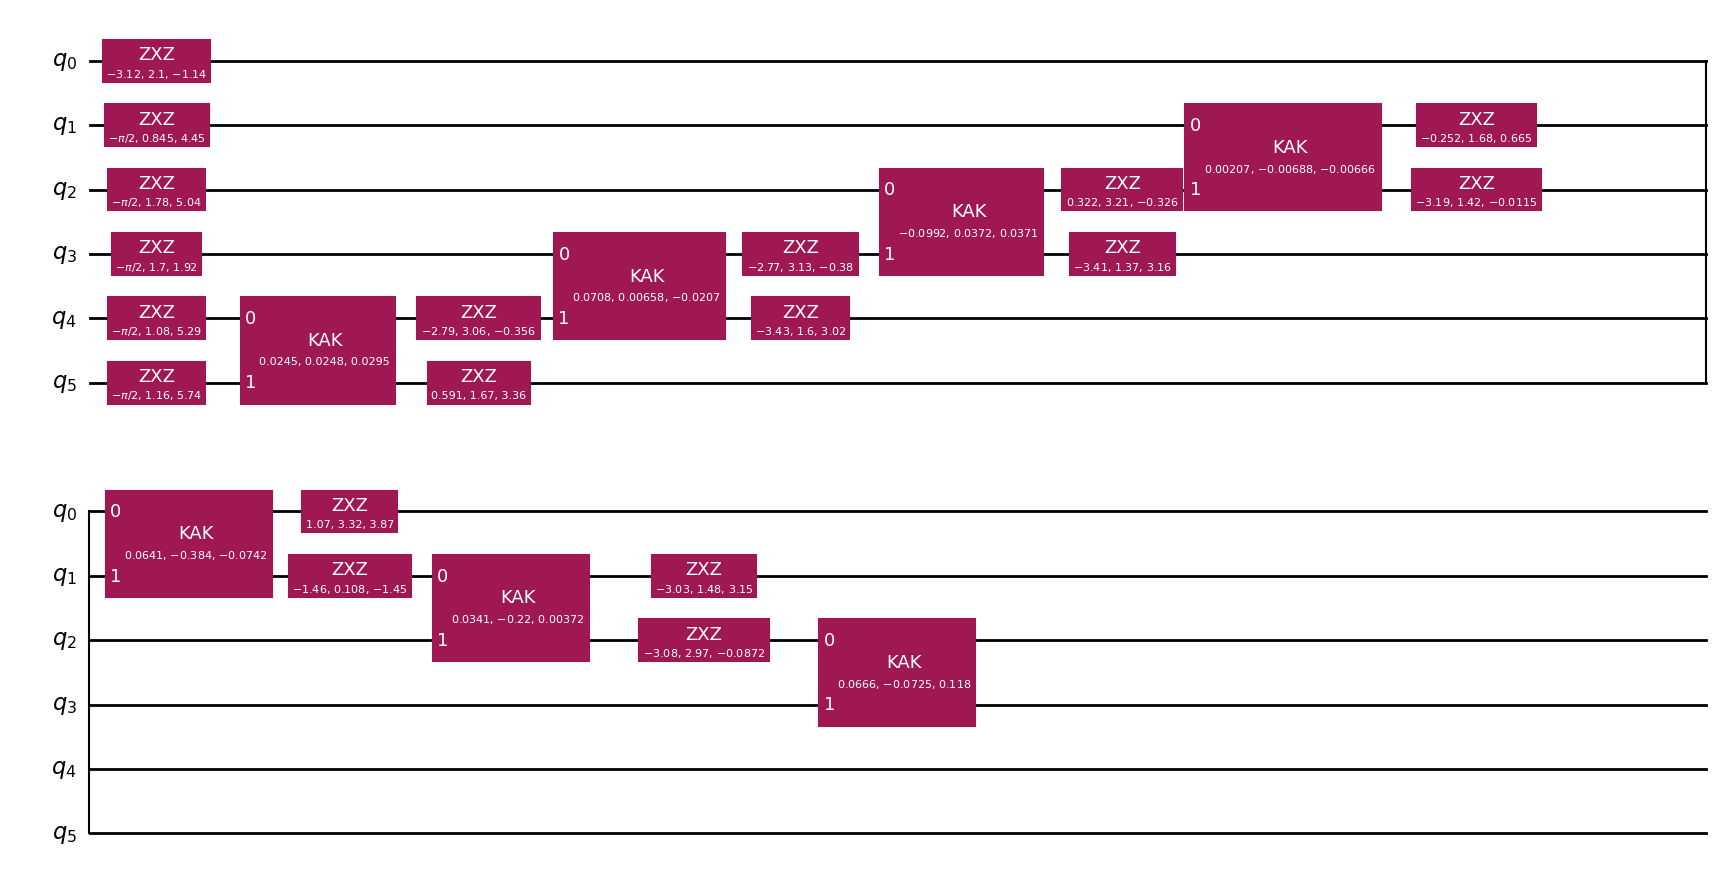

In [60]:
print("=== Compressed Optimised Circuit ===")
aqc_optimised_compressed = aqc_ansatz_compressed.assign_parameters(aqc_final_parameters_compressed)
aqc_optimised_compressed.draw("mpl")

In [61]:
print("\n=== Compressed Optimised Parameters ===")
for param, value in zip(aqc_ansatz_compressed.parameters, aqc_final_parameters_compressed):
    print(f"{param}: {value:.6f}")

df_params = pd.DataFrame({'parameters': aqc_final_parameters_compressed})
df_params.to_csv('aqc_initial_parameters_Ising.csv', index=False)


=== Compressed Optimised Parameters ===
theta[0]: -3.117593
theta[1]: 2.097310
theta[2]: -1.135821
theta[3]: -1.570796
theta[4]: 0.844802
theta[5]: 4.454441
theta[6]: -1.570796
theta[7]: 1.779699
theta[8]: 5.043899
theta[9]: -1.570796
theta[10]: 1.698122
theta[11]: 1.920504
theta[12]: -1.570796
theta[13]: 1.077177
theta[14]: 5.294838
theta[15]: -1.570796
theta[16]: 1.164905
theta[17]: 5.736057
theta[18]: 0.024510
theta[19]: 0.024790
theta[20]: 0.029488
theta[21]: -2.789985
theta[22]: 3.060420
theta[23]: -0.356227
theta[24]: 0.591391
theta[25]: 1.665663
theta[26]: 3.357012
theta[27]: 0.070759
theta[28]: 0.006585
theta[29]: -0.020686
theta[30]: -2.765598
theta[31]: 3.132073
theta[32]: -0.379879
theta[33]: -3.427353
theta[34]: 1.596758
theta[35]: 3.021648
theta[36]: -0.099176
theta[37]: 0.037246
theta[38]: 0.037069
theta[39]: 0.322388
theta[40]: 3.209938
theta[41]: -0.326158
theta[42]: -3.412754
theta[43]: 1.367736
theta[44]: 3.157354
theta[45]: 0.002070
theta[46]: -0.006875
theta[47]: -

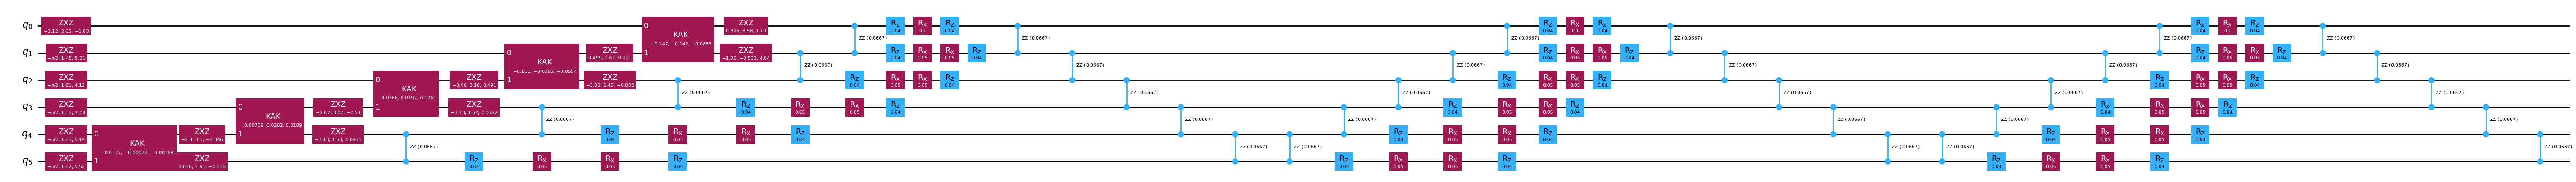

In [22]:
param_binding = {param: value for param, value in zip(aqc_optimised_compressed.parameters, aqc_final_parameters_compressed)}
aqc_final_circuit = aqc_optimised_compressed.assign_parameters(param_binding)
aqc_final_circuit.compose(subsequent_circuit, inplace=True)
aqc_final_circuit.draw("mpl", fold=-1)

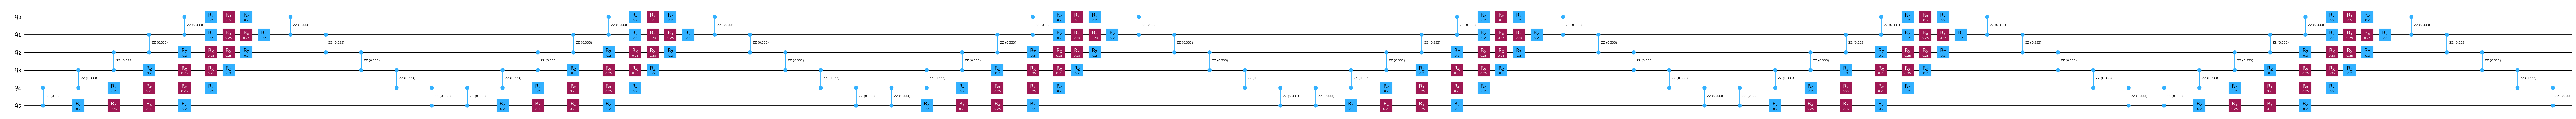

In [ ]:
# merge comparison circuit with remaining time evolution circuit also
aqc_comparison_circuit.compose(subsequent_circuit, inplace=True)
aqc_comparison_circuit.draw("mpl", fold=-1)

Optimise problem for quantum execution

In [205]:
from qiskit_ibm_runtime import QiskitRuntimeService

# QiskitRuntimeService.save_account(channel="ibm_quantum", token="<MY_IBM_QUANTUM_TOKEN>", overwrite=True, set_as_default=True)
service = QiskitRuntimeService(channel='ibm_quantum')
backend = service.least_busy(min_num_qubits=127)
print(backend)

<IBMBackend('ibm_sherbrooke')>


Observable info: SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZ'],
              coeffs=[1.+0.j])
Circuit depth: 230


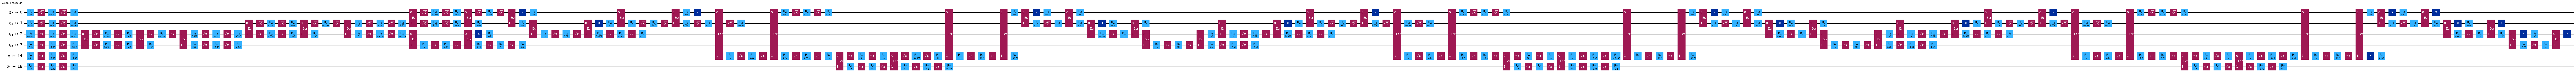

In [251]:
# transpiler optimises cirucit to fit a 1D chain of qubits, reducing the noise impacting the cirucit fidelity
from qiskit import transpile
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pass_manager = generate_preset_pass_manager(backend=backend, optimization_level=3)
isa_circuit = pass_manager.run(aqc_final_circuit)
isa_observable = observable.apply_layout(isa_circuit.layout)
print("Observable info:", isa_observable)
print("Circuit depth:", isa_circuit.depth())
isa_circuit.draw("mpl", fold=-1, idle_wires=False)

Observable info: SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII'],
              coeffs=[1.+0.j])
Circuit depth: 393


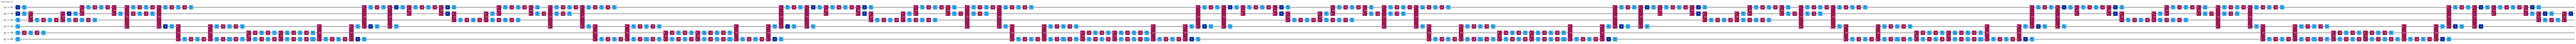

In [ ]:
# transpilation for the comparison cirucit
isa_comparison_circuit = pass_manager.run(aqc_comparison_circuit)
isa_comparison_observable = observable.apply_layout(isa_comparison_circuit.layout)
print("Observable info:", isa_comparison_observable)
print("Circuit depth:", isa_comparison_circuit.depth())
isa_comparison_circuit.draw("mpl", fold=-1, idle_wires=False)

Execute using Qiskit primitives

In [24]:
from qiskit_ibm_runtime import EstimatorV2 as Estimator

estimator = Estimator(backend)
job = estimator.run([(isa_circuit, isa_observable)])
print("Job ID:", job.job_id())
job.result()

Job ID: czwem60kzhn0008d06pg


PrimitiveResult([PubResult(data=DataBin(evs=np.ndarray(<shape=(), dtype=float64>), stds=np.ndarray(<shape=(), dtype=float64>), ensemble_standard_error=np.ndarray(<shape=(), dtype=float64>)), metadata={'shots': 4096, 'target_precision': 0.015625, 'circuit_metadata': {}, 'resilience': {}, 'num_randomizations': 32})], metadata={'dynamical_decoupling': {'enable': False, 'sequence_type': 'XX', 'extra_slack_distribution': 'middle', 'scheduling_method': 'alap'}, 'twirling': {'enable_gates': False, 'enable_measure': True, 'num_randomizations': 'auto', 'shots_per_randomization': 'auto', 'interleave_randomizations': True, 'strategy': 'active-accum'}, 'resilience': {'measure_mitigation': True, 'zne_mitigation': False, 'pec_mitigation': False}, 'version': 2})

In [25]:
# for the comparison cirucit
job_comparison = estimator.run([(isa_comparison_circuit, isa_observable)])
print("Job Comparison ID:", job.job_id())
job_comparison.result()

Job Comparison ID: czwem60kzhn0008d06pg


PrimitiveResult([PubResult(data=DataBin(evs=np.ndarray(<shape=(), dtype=float64>), stds=np.ndarray(<shape=(), dtype=float64>), ensemble_standard_error=np.ndarray(<shape=(), dtype=float64>)), metadata={'shots': 4096, 'target_precision': 0.015625, 'circuit_metadata': {}, 'resilience': {}, 'num_randomizations': 32})], metadata={'dynamical_decoupling': {'enable': False, 'sequence_type': 'XX', 'extra_slack_distribution': 'middle', 'scheduling_method': 'alap'}, 'twirling': {'enable_gates': False, 'enable_measure': True, 'num_randomizations': 'auto', 'shots_per_randomization': 'auto', 'interleave_randomizations': True, 'strategy': 'active-accum'}, 'resilience': {'measure_mitigation': True, 'zne_mitigation': False, 'pec_mitigation': False}, 'version': 2})

Post-processing

In [26]:
# AQC results
import numpy as np
hw_results = job.result()
hw_results_dicts = [pub_result.data.__dict__ for pub_result in hw_results]
hw_expvals = [pub_result_data["evs"].tolist() for pub_result_data in hw_results_dicts]
aqc_expval = hw_expvals[0]

# AQC comparison results
hw_comparison_results = job_comparison.result()
hw_comparison_results_dicts = [pub_result.data.__dict__ for pub_result in hw_comparison_results]
hw_comparison_expvals = [pub_result_data["evs"].tolist() for pub_result_data in hw_comparison_results_dicts]
aqc_compare_expval = hw_comparison_expvals[0]

print(f"Exact:         \t{reference_expval:.4f}")
print(f"AQC:           \t{aqc_expval:.4f}, |∆| = {np.abs(reference_expval- aqc_expval):.4f}")
print(f"AQC Comparison:\t{aqc_compare_expval:.4f}, |∆| = {np.abs(reference_expval- aqc_compare_expval):.4f}")

Exact:         	-0.7448
AQC:           	-0.2412, |∆| = 0.5036
AQC Comparison:	0.3467, |∆| = 1.0915


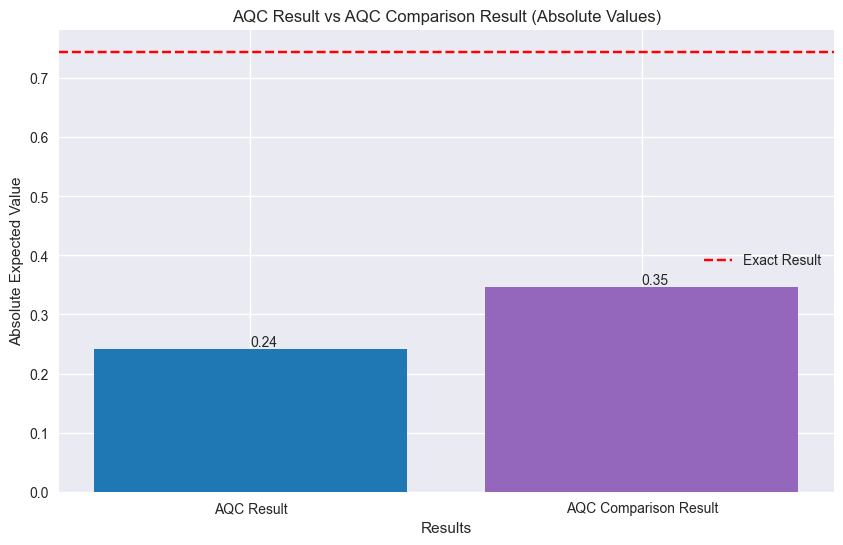

In [27]:
# Bar plot to comapre results
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')

labels = ['AQC Result', 'AQC Comparison Result']
values = [abs(aqc_expval), abs(aqc_compare_expval)]

plt.figure(figsize=(10, 6))
bars = plt.bar(labels, values, color=['tab:blue', 'tab:purple'])
plt.axhline(y=abs(reference_expval), color='red', linestyle='--', label='Exact Result')
plt.xlabel('Results')
plt.ylabel('Absolute Expected Value')
plt.title('AQC Result vs AQC Comparison Result (Absolute Values)')
plt.legend()
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 2), va='bottom')  
plt.show()

# Heisenberg Model

In [45]:
# Heisenberg
evolution_time = 0.2
h = 0.75
system = 'heisenberg'

terms_h, params_h = get_hamiltonian_terms(num_qubits=num_sites, system=system, J=[1.0, 1.0, -0.5], h=[0.75, 0.0, 0.0])

J= params_h['J']
h= params_h['h']

In [46]:
from ropt_aqc.initialise_hamiltonians import hamiltonian_to_sparse_pauli_op
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler import CouplingMap

hamiltonian_heisenberg = hamiltonian_to_sparse_pauli_op(terms_h, num_qubits=num_sites)
print('Hamiltonian: ', hamiltonian_heisenberg)

observable = SparsePauliOp.from_sparse_list(
    [("ZZ", (num_sites // 2 - 1, num_sites // 2), 1.0)], num_qubits=num_sites
)
print("Observable:", observable)

Hamiltonian:  SparsePauliOp(['XXIIII', 'YYIIII', 'ZZIIII', 'IXXIII', 'IYYIII', 'IZZIII', 'IIXXII', 'IIYYII', 'IIZZII', 'IIIXXI', 'IIIYYI', 'IIIZZI', 'IIIIXX', 'IIIIYY', 'IIIIZZ', 'XIIIII', 'IXIIII', 'IIXIII', 'IIIXII', 'IIIIXI', 'IIIIIX'],
              coeffs=[ 1.  +0.j,  1.  +0.j, -0.5 +0.j,  1.  +0.j,  1.  +0.j, -0.5 +0.j,
  1.  +0.j,  1.  +0.j, -0.5 +0.j,  1.  +0.j,  1.  +0.j, -0.5 +0.j,
  1.  +0.j,  1.  +0.j, -0.5 +0.j,  0.75+0.j,  0.75+0.j,  0.75+0.j,
  0.75+0.j,  0.75+0.j,  0.75+0.j])
Observable: SparsePauliOp(['IIZZII'],
              coeffs=[1.+0.j])


In [47]:
# Generate an initial state
initial_state = QuantumCircuit(num_sites)
for i in range(num_sites):
    if i % 2:
        initial_state.x(i)

In [48]:
aqc_evolution_time = evolution_time
aqc_target_num_trotter_steps = 32

aqc_target_circuit_h = initial_state.copy()
aqc_target_circuit_h.compose(
    generate_time_evolution_circuit(
        hamiltonian_heisenberg,
        synthesis=SuzukiTrotter(reps=aqc_target_num_trotter_steps),
        time=aqc_evolution_time,
    ),
    inplace=True,
)

In [49]:
subsequent_num_trotter_steps = 3
subsequent_evolution_time = 0.2

subsequent_circuit_h = generate_time_evolution_circuit(
        hamiltonian_heisenberg,
        synthesis=SuzukiTrotter(reps=subsequent_num_trotter_steps),
        time=subsequent_evolution_time,
    )

In [50]:
# Generate the AQC comparison circuit
aqc_comparison_num_trotter_steps = int(
    subsequent_num_trotter_steps / subsequent_evolution_time * aqc_evolution_time
)
print("Number of Trotter steps for comparison:", aqc_comparison_num_trotter_steps)

aqc_comparison_circuit_h = generate_time_evolution_circuit(
    hamiltonian_heisenberg,
    synthesis=SuzukiTrotter(reps=aqc_comparison_num_trotter_steps),
    time=aqc_evolution_time,
)

Number of Trotter steps for comparison: 3


In [51]:
evolution_time = evolution_time
reps = 200

reference_circuit_h = initial_state.copy()
reference_circuit_h.compose(
    generate_time_evolution_circuit(
        hamiltonian_heisenberg,
        synthesis=SuzukiTrotter(reps=reps),
        time=evolution_time,
    ),
    inplace=True,
)

In [52]:
aqc_ansatz_num_trotter_steps = n_repetitions

aqc_good_circuit_h = initial_state.copy()
aqc_good_circuit_h.compose(
    generate_time_evolution_circuit(
        hamiltonian_heisenberg,
        synthesis=SuzukiTrotter(reps=aqc_ansatz_num_trotter_steps),
        time=aqc_evolution_time,
    ),
    inplace=True,
)

aqc_ansatz_h, aqc_initial_parameters_h = generate_ansatz_from_circuit(aqc_good_circuit_h)

In [53]:
print(f"AQC Comparison circuit: depth {aqc_comparison_circuit_h.depth()}")
print(f"Target circuit:         depth {aqc_target_circuit_h.depth()}")
print(f"Ansatz circuit:         depth {aqc_ansatz_h.depth()}, with {len(aqc_initial_parameters_h)} parameters")

AQC Comparison circuit: depth 96
Target circuit:         depth 1025
Ansatz circuit:         depth 83, with 387 parameters


In [54]:
simulator_settings = QuimbSimulator(quimb.tensor.CircuitMPS, autodiff_backend="jax")

# Build the matrix-product representation of the state to be approximated by AQC
aqc_target_mps_h = tensornetwork_from_circuit(aqc_target_circuit_h, simulator_settings)
print("Target MPS maximum bond dimension:", aqc_target_mps_h.psi.max_bond())

# Obtains the reference MPS, where we can obtain the exact expectation value by examing the `local_expectation``
reference_mps_h  = tensornetwork_from_circuit(reference_circuit_h, simulator_settings)
reference_expval_h = reference_mps_h.local_expectation(quimb.pauli('Z') & quimb.pauli('Z'), (num_sites // 2 - 1, num_sites // 2)).real.item()
print("Reference MPS maximum bond dimension:", reference_mps_h.psi.max_bond())

Target MPS maximum bond dimension: 5
Reference MPS maximum bond dimension: 4


In [55]:
from ropt_aqc.comparison_methods import compress_AQC

N_vals = range(1, 30)

df_h, aqc_truncated_h, aqc_initial_parameters_h, aqc_final_parameters_h = compress_AQC(aqc_ansatz_h, aqc_good_circuit_h, aqc_comparison_circuit_h, aqc_target_circuit_h, aqc_initial_parameters_h, N_vals, simulator_settings, aqc_target_mps_h, n_repetitions)


=== Optimizing with N = 1 layers ===
Parameters in truncated ansatz: ParameterView([ParameterVectorElement(theta[0]), ParameterVectorElement(theta[1]), ParameterVectorElement(theta[2]), ParameterVectorElement(theta[3]), ParameterVectorElement(theta[4]), ParameterVectorElement(theta[5]), ParameterVectorElement(theta[6]), ParameterVectorElement(theta[7]), ParameterVectorElement(theta[8]), ParameterVectorElement(theta[9]), ParameterVectorElement(theta[10]), ParameterVectorElement(theta[11]), ParameterVectorElement(theta[12]), ParameterVectorElement(theta[13]), ParameterVectorElement(theta[14]), ParameterVectorElement(theta[15]), ParameterVectorElement(theta[16]), ParameterVectorElement(theta[17])])
Truncated parameter values: [ 1.25455202e-13  3.00539511e-02 -1.30784272e-13  1.31922348e+00
  0.00000000e+00  4.46081613e+00 -3.85335974e+00  0.00000000e+00
 -7.11767086e-01 -1.66897110e+00  0.00000000e+00  1.47262156e+00
 -1.96349541e+00  0.00000000e+00  1.17809725e+00 -7.85398163e-01
  3.14

In [56]:
import pandas as pd
file_path_heisenberg = f'/Users/aag/Documents/ropt-aqc/method_comparison/results/AQC_initial_Heisenberg_results_{evolution_time}.csv'

df_h.to_csv(file_path_heisenberg, index=False, header=True)
# df_h.to_csv(file_path_heisenberg, index=False, mode="a", header=False)


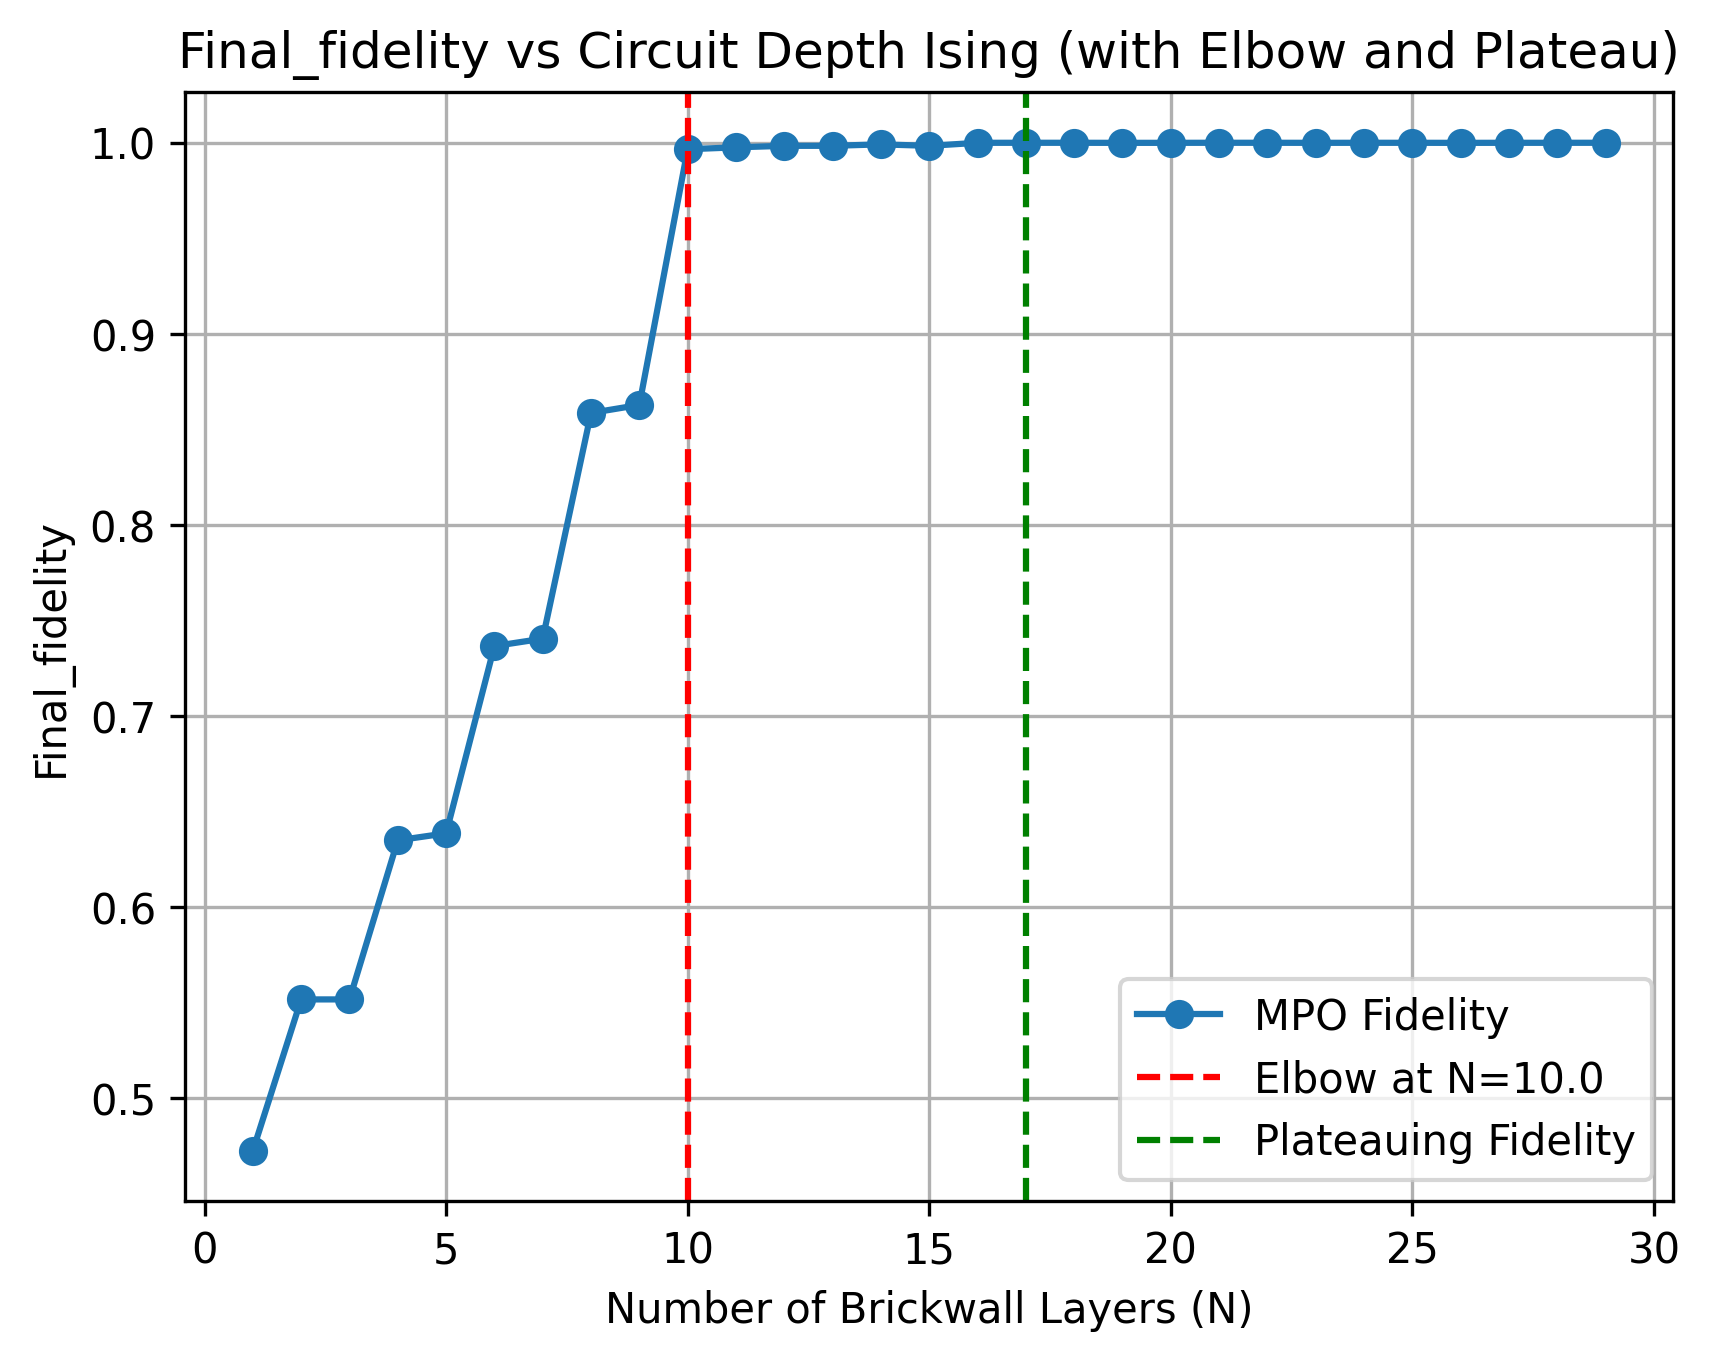


🔍 Suggested optimal compression depth: N = 17.0


In [57]:
from ropt_aqc.brickwall_opt import plot_fidelity
df_h = pd.read_csv(file_path_heisenberg)
elbow_N_h, plateau_N_h = plot_fidelity(df_h, 'Final_fidelity', evolution_time, 1e-3, method, system,save_path=True)

In [37]:
# Compress circuit
N_vals = [int(plateau_N)]
df_compressed_h, aqc_ansatz_compressed_h, aqc_initial_parameters_compressed_h, aqc_final_parameters_compressed_h = compress_AQC(aqc_ansatz_h, aqc_good_circuit_h, aqc_comparison_circuit_h, aqc_target_circuit_h, aqc_initial_parameters_h, N_vals, simulator_settings, aqc_target_mps_h, n_repetitions)


=== Optimizing with N = 11 layers ===
Parameters in truncated ansatz: ParameterView([ParameterVectorElement(theta[0]), ParameterVectorElement(theta[1]), ParameterVectorElement(theta[2]), ParameterVectorElement(theta[3]), ParameterVectorElement(theta[4]), ParameterVectorElement(theta[5]), ParameterVectorElement(theta[6]), ParameterVectorElement(theta[7]), ParameterVectorElement(theta[8]), ParameterVectorElement(theta[9]), ParameterVectorElement(theta[10]), ParameterVectorElement(theta[11]), ParameterVectorElement(theta[12]), ParameterVectorElement(theta[13]), ParameterVectorElement(theta[14]), ParameterVectorElement(theta[15]), ParameterVectorElement(theta[16]), ParameterVectorElement(theta[17]), ParameterVectorElement(theta[18]), ParameterVectorElement(theta[19]), ParameterVectorElement(theta[20]), ParameterVectorElement(theta[21]), ParameterVectorElement(theta[22]), ParameterVectorElement(theta[23]), ParameterVectorElement(theta[24]), ParameterVectorElement(theta[25]), ParameterVecto

=== Compressed Optimised Circuit ===


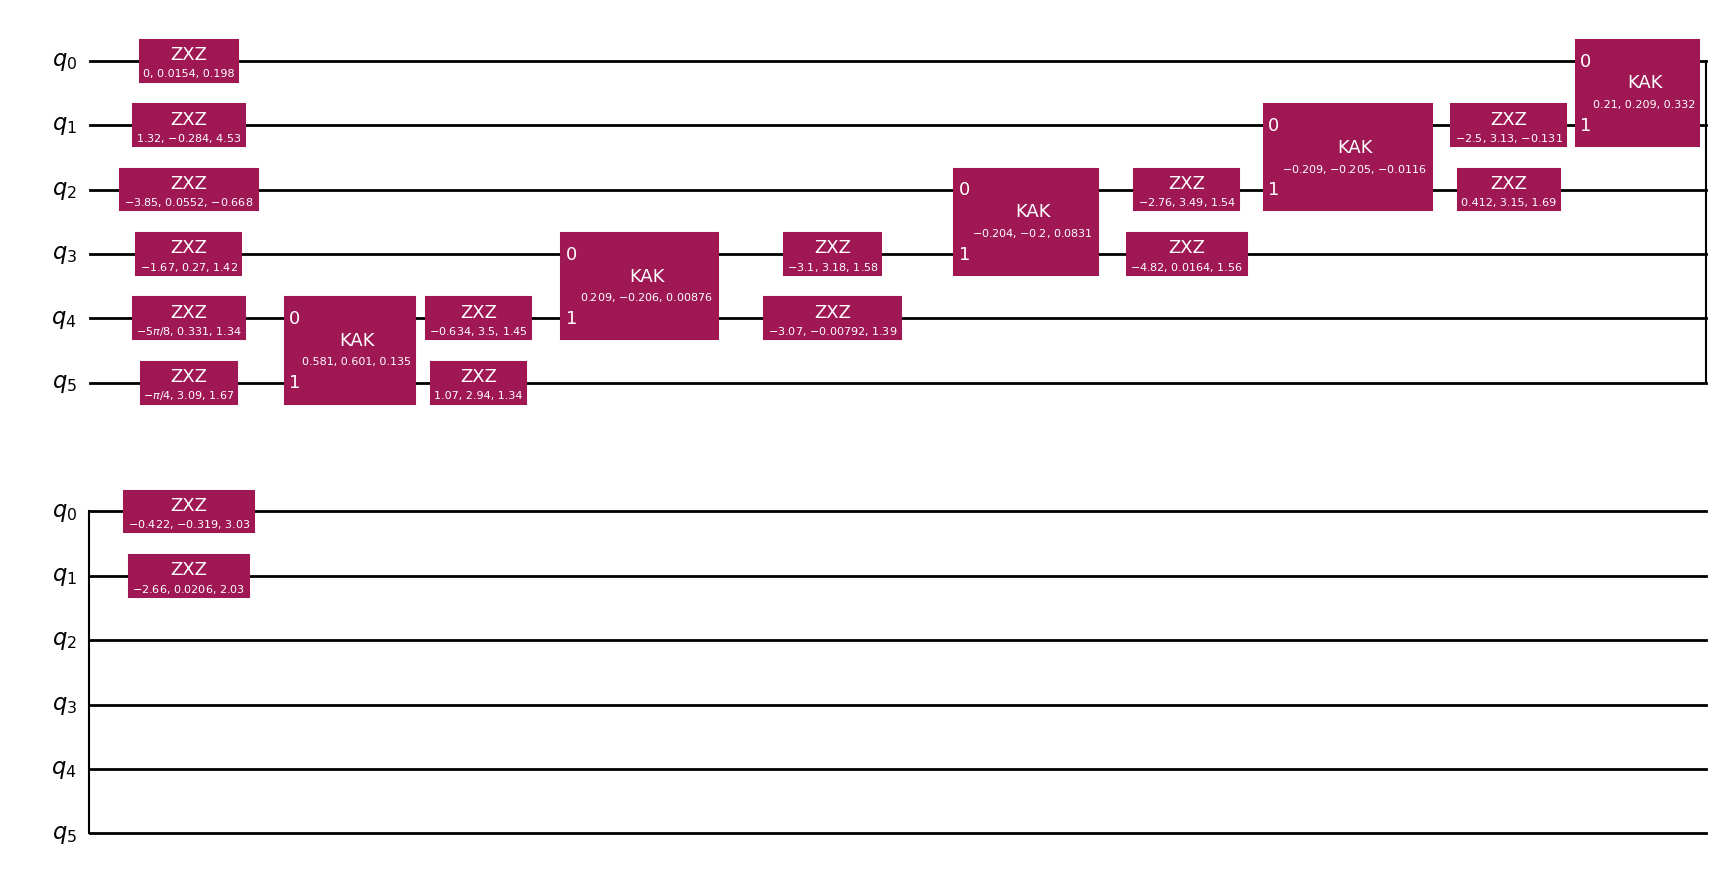

In [38]:
print("=== Compressed Optimised Circuit ===")
aqc_optimised_compressed_h = aqc_ansatz_compressed_h.assign_parameters(aqc_final_parameters_compressed_h)
aqc_optimised_compressed_h.draw("mpl")

In [39]:
print("\n=== Compressed Optimised Parameters ===")
for param, value in zip(aqc_ansatz_compressed_h.parameters, aqc_final_parameters_compressed_h):
    print(f"{param}: {value:.6f}")


=== Compressed Optimised Parameters ===
theta[0]: 0.000000
theta[1]: 0.015398
theta[2]: 0.197531
theta[3]: 1.319223
theta[4]: -0.283694
theta[5]: 4.533773
theta[6]: -3.853360
theta[7]: 0.055230
theta[8]: -0.667992
theta[9]: -1.668971
theta[10]: 0.270005
theta[11]: 1.421729
theta[12]: -1.963495
theta[13]: 0.331211
theta[14]: 1.338783
theta[15]: -0.785398
theta[16]: 3.088040
theta[17]: 1.666623
theta[18]: 0.580913
theta[19]: 0.600833
theta[20]: 0.135223
theta[21]: -0.633795
theta[22]: 3.498985
theta[23]: 1.448844
theta[24]: 1.065316
theta[25]: 2.944585
theta[26]: 1.336858
theta[27]: 0.209251
theta[28]: -0.206151
theta[29]: 0.008760
theta[30]: -3.104372
theta[31]: 3.184749
theta[32]: 1.578806
theta[33]: -3.066900
theta[34]: -0.007921
theta[35]: 1.386550
theta[36]: -0.204404
theta[37]: -0.200092
theta[38]: 0.083059
theta[39]: -2.764719
theta[40]: 3.491389
theta[41]: 1.542388
theta[42]: -4.820549
theta[43]: 0.016428
theta[44]: 1.563807
theta[45]: -0.208939
theta[46]: -0.205041
theta[47]: -

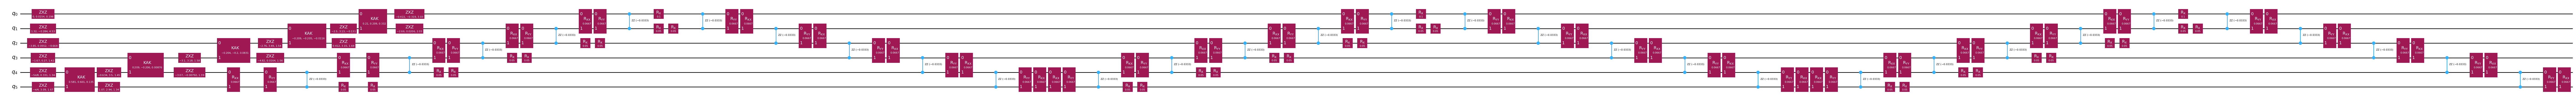

In [40]:
param_binding_h = {param: value for param, value in zip(aqc_optimised_compressed_h.parameters, aqc_final_parameters_compressed_h)}
aqc_final_circuit_h = aqc_optimised_compressed_h.assign_parameters(param_binding_h)
aqc_final_circuit_h.compose(subsequent_circuit_h, inplace=True)
aqc_final_circuit_h.draw("mpl", fold=-1)

In [43]:
aqc_comparison_circuit_h.compose(subsequent_circuit_h, inplace=True)


In [ ]:
# QiskitRuntimeService.save_account(channel="ibm_quantum", token="<MY_IBM_QUANTUM_TOKEN>", overwrite=True, set_as_default=True)
service = QiskitRuntimeService(channel='ibm_quantum')
backend = service.least_busy(min_num_qubits=127)
print(backend)

<IBMBackend('ibm_sherbrooke')>


In [60]:
pass_manager = generate_preset_pass_manager(backend=backend, optimization_level=3)
isa_circuit_h = pass_manager.run(aqc_final_circuit_h)
isa_observable_h = observable.apply_layout(isa_circuit_h.layout)
print("Observable info:", isa_observable_h)
print("Circuit depth:", isa_circuit_h.depth())
isa_circuit_h.draw("mpl", fold=-1, idle_wires=False)

NameError: name 'generate_preset_pass_manager' is not defined

Observable info: SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZ'],
              coeffs=[1.+0.j])
Circuit depth: 596


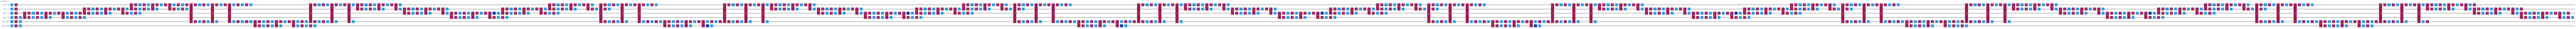

In [ ]:
isa_comparison_circuit = pass_manager.run(aqc_comparison_circuit_h)
isa_comparison_observable = observable.apply_layout(isa_comparison_circuit.layout)
print("Observable info:", isa_comparison_observable)
print("Circuit depth:", isa_comparison_circuit.depth())
isa_comparison_circuit.draw("mpl", fold=-1, idle_wires=False)

In [45]:
twirling_options = {
    "enable_gates": True,
    "enable_measure": True,
    "num_randomizations": 300,
    "shots_per_randomization": 100,
    "strategy": "active",
}

zne_options = {
    "amplifier": "gate_folding",
    "noise_factors": [1, 2, 3],
    "extrapolated_noise_factors": list(np.linspace(0, 3, 31)),
    "extrapolator": ["exponential", "linear", "fallback"],
}

meas_learning_options = {"num_randomizations": 512, "shots_per_randomization": 512}

resilience_options = {
    "measure_mitigation": True,
    "zne_mitigation": True,
    "zne": zne_options,
    "measure_noise_learning": meas_learning_options,
}

estimator_options = {
    "resilience": resilience_options,
    "twirling": twirling_options,
}

estimator = Estimator(backend, options=estimator_options)

In [46]:
job = estimator.run([(isa_circuit_h, isa_observable_h)])
print("Job ID:", job.job_id())
job.result()

Job ID: czwepxbrxz8g008excbg


PrimitiveResult([PubResult(data=DataBin(evs=np.ndarray(<shape=(), dtype=float64>), stds=np.ndarray(<shape=(), dtype=float64>), evs_noise_factors=np.ndarray(<shape=(3,), dtype=float64>), stds_noise_factors=np.ndarray(<shape=(3,), dtype=float64>), ensemble_stds_noise_factors=np.ndarray(<shape=(3,), dtype=float64>), evs_extrapolated=np.ndarray(<shape=(3, 31), dtype=float64>), stds_extrapolated=np.ndarray(<shape=(3, 31), dtype=float64>)), metadata={'shots': 30000, 'target_precision': 0.005773502691896258, 'circuit_metadata': {}, 'resilience': {'zne': {'extrapolator': 'exponential'}}, 'num_randomizations': 300})], metadata={'dynamical_decoupling': {'enable': False, 'sequence_type': 'XX', 'extra_slack_distribution': 'middle', 'scheduling_method': 'alap'}, 'twirling': {'enable_gates': True, 'enable_measure': True, 'num_randomizations': 300, 'shots_per_randomization': 100, 'interleave_randomizations': True, 'strategy': 'active'}, 'resilience': {'measure_mitigation': True, 'zne_mitigation': Tru

In [47]:
job_comparison = estimator.run([(isa_comparison_circuit, isa_observable_h)])
print("Job Comparison ID:", job.job_id())
job_comparison.result()

IBMRuntimeError: 'Failed to run program: \'403 Client Error: Forbidden for url: https://api.quantum.ibm.com/runtime/jobs. {"errors":[{"message":"Job create exceeds open plan job usage limits","code":4317,"solution":"Please wait until the beginning of next month to submit more jobs when your quota will reset.","more_info":"https://docs.quantum-computing.ibm.com/errors"}]}\''

In [76]:
# AQC results
hw_results = job.result()
hw_results_dicts = [pub_result.data.__dict__ for pub_result in hw_results]
hw_expvals = [pub_result_data["evs"].tolist() for pub_result_data in hw_results_dicts]
aqc_expval = hw_expvals[0]

# AQC comparison results
hw_comparison_results = job_comparison.result()
hw_comparison_results_dicts = [pub_result.data.__dict__ for pub_result in hw_comparison_results]
hw_comparison_expvals = [pub_result_data["evs"].tolist() for pub_result_data in hw_comparison_results_dicts]
aqc_compare_expval = hw_comparison_expvals[0]

print(f"Exact:         \t{reference_expval:.4f}")
print(f"AQC:           \t{aqc_expval:.4f}, |∆| = {np.abs(reference_expval- aqc_expval):.4f}")
print(f"AQC Comparison:\t{aqc_compare_expval:.4f}, |∆| = {np.abs(reference_expval- aqc_compare_expval):.4f}")

Exact:         	-0.5888
AQC:           	-0.5711, |∆| = 0.0176
AQC Comparison:	0.9940, |∆| = 1.5827


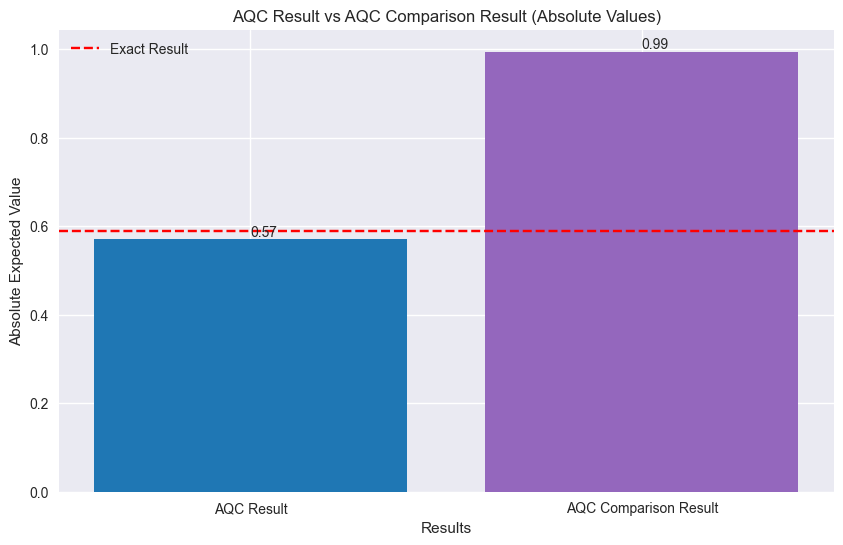

In [77]:
labels = ['AQC Result', 'AQC Comparison Result']
values = [abs(aqc_expval), abs(aqc_compare_expval)]

plt.figure(figsize=(10, 6))
bars = plt.bar(labels, values, color=['tab:blue', 'tab:purple'])
plt.axhline(y=abs(reference_expval), color='red', linestyle='--', label='Exact Result')
plt.xlabel('Results')
plt.ylabel('Absolute Expected Value')
plt.title('AQC Result vs AQC Comparison Result (Absolute Values)')
plt.legend()
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 2), va='bottom')  

plt.show()